# Import libraries and data

In [1]:
# import libraries 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns

from matplotlib_venn import venn2
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats.multitest import multipletests

from utils import increase_stringency_CSF, print_p_val, preprocess

In [2]:
data_path = os.getcwd() + "/Datasets/"
fig_path = os.getcwd() + "/Figures/"

## Feature brain data set

In [3]:
df_features = pd.read_csv(data_path + "/Features/df_features_brain_elevated_MS_filtered.csv")

In [4]:
# drop non-sequence-based features
df_features.drop(["RNA_binding", "DNA_binding", "Ectodomain_shedding", "EV"], axis=1, inplace=True)

## CSF data set

In [5]:
csf = pd.read_csv(data_path + "CSF/csf.csv")

## DeepSec predictions

In [6]:
deepsec_test_set = pd.read_csv(data_path + "Biomarker_discovery/DeepSec_test_set_CSF3+.txt", sep="\t", header=None, 
    names=["Uniprot", "Probability_DeepSec"])
deepsec_pea = pd.read_csv(data_path + "Biomarker_discovery/DeepSec_PEA_non_mass_spec_proteins.txt", sep="\t", header=None, 
    names=["Uniprot", "Probability_DeepSec"])
print("Number of test set proteins with DeepSec probability score:", len(deepsec_test_set))
print("Number of PEA-detected proteins with DeepSec probability score:", len(deepsec_pea))

Number of test set proteins with DeepSec probability score: 343
Number of PEA-detected proteins with DeepSec probability score: 197


## Model and scaler

In [7]:
with open(os.getcwd() + "/Models/LogisticClassifier_L2_3plus.pkl", "rb") as f:  
    L2_CSF3 = pickle.load(f)
with open(os.getcwd() + "/Models/Standard_scaler.pkl", "rb") as f:  
    scaler = pickle.load(f)

# Method comparison

## Extract test set 

In [8]:
# create CSF3+ dataset
df_stringent = increase_stringency_CSF(df_features, csf, 3)

Number of CSF proteins to be removed: 367
Number of CSF proteins left: 525


In [9]:
# define variables and target
X = df_stringent.drop(["Uniprot", "Sequence", "CSF"], axis=1)
y = df_stringent["CSF"]

In [10]:
# create training and test sets that were used for final CSF3+ classifier
X_train_bal, X_test_scal, y_train_bal, y_test, scaler = preprocess(X, y, random_state=9)

# merge with feature dataframe to match Uniprot IDs
test_set_classes = X_test_scal.join(df_features[["Uniprot", "CSF"]])[["Uniprot", "CSF"]]
test_set_uniprots = set(test_set_classes["Uniprot"])
print("Number of Uniprots in test set:", len(test_set_uniprots))
print("Number of CSF proteins in test set:", len(y_test[y_test == 1]))
print("Number of non-CSF proteins in test set:", len(y_test[y_test == -1]))

Number of Uniprots in test set: 343
Number of CSF proteins in test set: 105
Number of non-CSF proteins in test set: 238


## CSF3+ predictions

In [11]:
# predict with CSF3+ classifier on test set
y_pred = L2_CSF3.predict(X_test_scal)

print("Balanced accuracy: %.2f" % (balanced_accuracy_score(y_test, y_pred)*100))
print("Sensitivity: %.2f" % (recall_score(y_test, y_pred)*100))
print("ROC-AUC: %.2f" % roc_auc_score(y_test, L2_CSF3.predict_proba(X_test_scal)[:, 1]))

Balanced accuracy: 78.99
Sensitivity: 71.43
ROC-AUC: 0.87


In [12]:
predictions_CSF3 = test_set_classes
predictions_CSF3["Probability_CSF3+"] = L2_CSF3.predict_proba(X_test_scal)[:, 1].tolist()
predictions_CSF3["Classes_CSF3+"] = y_pred
predictions_CSF3

,Uniprot,CSF,Probability_CSF3+,Classes_CSF3+
1687,Q96S95,-1,0.298433,-1
516,Q8IUS5,-1,0.142454,-1
389,Q96GW7,1,0.980078,1
540,Q02156,-1,0.121064,-1
1257,P20382,1,0.896042,1
...,...,...,...,...
408,Q05329,-1,0.159471,-1
387,Q5JQF8,-1,0.361305,-1
1357,O76070,1,0.989350,1
10,Q9H313,-1,0.179907,-1


## DeepSec predictions

In [13]:
deepsec_test_set["Class_DeepSec"] = np.where(deepsec_test_set["Probability_DeepSec"] > 0.5, 1, -1)

In [14]:
predictions_comb = test_set_classes.merge(deepsec_test_set, on="Uniprot")
predictions_comb[:5]

,Uniprot,CSF,Probability_CSF3+,Classes_CSF3+,Probability_DeepSec,Class_DeepSec
0,Q96S95,-1,0.298433,-1,0.0481,-1
1,Q8IUS5,-1,0.142454,-1,0.0666,-1
2,Q96GW7,1,0.980078,1,0.9679,1
3,Q02156,-1,0.121064,-1,0.8371,1
4,P20382,1,0.896042,1,0.4987,-1


In [19]:
print("Balanced accuracy: %.2f%%" % (balanced_accuracy_score(predictions_comb["CSF"], 
    predictions_comb["Class_DeepSec"])*100))
print("Sensitivity: %.2f%%" % (recall_score(predictions_comb["CSF"], predictions_comb["Class_DeepSec"])*100))
print("ROC-AUC: %.2f" % roc_auc_score(predictions_comb["CSF"], predictions_comb["Probability_DeepSec"]))

Balanced accuracy: 70.74%
Sensitivity: 70.48%
ROC-AUC: 0.79


## Comparison of predictions

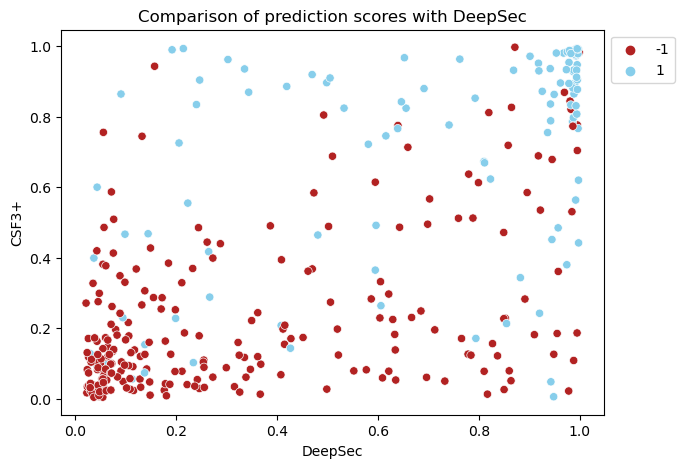

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))

sns.scatterplot(data=predictions_comb, x="Probability_DeepSec", y="Probability_CSF3+", hue="CSF", 
    palette=["firebrick", "skyblue"])
plt.legend(bbox_to_anchor=(1,1))
ax.set(title="Comparison of prediction scores with DeepSec", xlabel="DeepSec", ylabel="CSF3+")
plt.show()

## PEA-detected CSF proteins

In [17]:
print("Fraction of correctly predicted CSF proteins: %.2f%%" % (len(deepsec_pea[deepsec_pea["Probability_DeepSec"] > 0.5]) /
    len(deepsec_pea)*100))

Fraction of correctly predicted CSF proteins: 71.57%


In [18]:
print("Median probability score:", deepsec_pea["Probability_DeepSec"].median())

Median probability score: 0.7386
